## <center>Курсовой проект <a class="anchor" id="practice"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import catboost as catb
import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
TARGET_NAME = 'Credit Default'

train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

Вспомогательные классы и библиотеки

In [3]:
class ControllerPrepare:
    def __init__(self):
        self.default_Annual_Income = None
        self.unemployed = 'unemployed'
        self.default_Maximum_Open_Credit = None
        self.out_quan_Annual_Income = None
        self.out_quan_Maximum_Open_Credit = None
        self.Bankruptcies = None
        self.mean_Credit_Score = None
        self.out_quan_Credit_Score = None
    
    def get_info_from_train(self, df):
        #получаем среднее значение без выбросов
        #self.default_Annual_Income = df[(np.abs(stats.zscore(df['Annual Income'])) < 3)]['Annual Income'].mean()
        #self.default_Maximum_Open_Credit = df[(np.abs(stats.zscore(df['Maximum Open Credit'])) < 3)]['Maximum Open Credit'].mean()
        self.default_Annual_Income = df['Annual Income'].mean()
        self.default_Maximum_Open_Credit = df['Maximum Open Credit'].mean()
        self.out_quan_Annual_Income = df['Annual Income'].quantile(0.995)
        self.out_quan_Maximum_Open_Credit = df['Maximum Open Credit'].quantile(0.995)
        self.group1_month = df['Months since last delinquent'].quantile(0.25)
        self.group2_month = df['Months since last delinquent'].quantile(0.50)
        self.group3_month = df['Months since last delinquent'].quantile(0.75)
        self.nan_month = df['Months since last delinquent'].max() + df['Months since last delinquent'].std()
        self.Bankruptcies = df['Bankruptcies'].mode()[0]
        self.mean_Credit_Score = df['Credit Score'].mean()
        self.out_quan_Credit_Score = df['Credit Score'].quantile(0.995)
        return df
    
    def prepare(self, df):
        df = self.to_hot_cat(df)
        df = self.fillna_Annual_Income(df)
        df = self.fillna_Years_in_current_job(df)
        df = self.fillna_Maximum_Open_Credit(df)
        df = self.fillna_Months_since_last_delinquent(df)
        df = self.filna_Bankruptcies(df)
        df = self.fillna_Credit_Score(df)
        return df
    
    def to_hot_cat(self, df):
        df['Tax Liens'] = df['Tax Liens'].astype('int32')
        col_to_cat = ['Home Ownership', 'Tax Liens','Term', 'Purpose']
        for column_name in col_to_cat:
            df[column_name] = df[column_name].astype('category')
        return df
    
    def fillna_Annual_Income(self, df):
        df['Annual Income'] = df['Annual Income'].fillna(self.default_Annual_Income)
        df.loc[df['Annual Income'] > self.out_quan_Annual_Income, 'Annual Income'] = self.default_Annual_Income 
        return df
    
    def fillna_Maximum_Open_Credit(self, df):
        df.loc[df['Maximum Open Credit'] > self.out_quan_Maximum_Open_Credit, 'Maximum Open Credit'] = self.default_Maximum_Open_Credit
        return df
    
    def fillna_Years_in_current_job(self, df):
        df['Years in current job'] = df['Years in current job'].fillna(self.unemployed)
        df['Years in current job'] = df['Years in current job'].astype('category')
        return df
    
    def fillna_Months_since_last_delinquent(self, df):
        df.loc[df['Months since last delinquent'].isnull(), 'Months_category'] = '0'
        df.loc[df['Months since last delinquent'] <= self.group1_month, 'Months_category'] = '1'
        df.loc[(df['Months since last delinquent'] > self.group1_month) & 
               (df['Months since last delinquent'] <= self.group2_month), 'Months_category'] = '2'
        df.loc[(df['Months since last delinquent'] > self.group2_month) & 
               (df['Months since last delinquent'] <= self.group3_month), 'Months_category'] = '3'
        df.loc[df['Months since last delinquent'] > self.group3_month, 'Months_category']  = '4'
        df['Months_category'] = df['Months_category'].astype('category')
        
        df['Months since last delinquent'] = df['Months since last delinquent'].fillna(self.nan_month)     
        return df
    
    def filna_Bankruptcies(self,df):
        df['Bankruptcies'] = df['Bankruptcies'].fillna(self.Bankruptcies)
        return df
    
    def fillna_Credit_Score(self, df):
        df['Credit Score'] = df['Credit Score'].fillna(self.mean_Credit_Score)
        df.loc[df['Credit Score'] > self.out_quan_Credit_Score, 'Credit Score'] = self.mean_Credit_Score
        return df
    
    def get_and_prepare(self, df):
        self.get_info_from_train(df)
        self.prepare(df)
        return df
        
    def normalize(self, df, feats):
        scaler = StandardScaler()

        df_norm = df.copy()
        df_norm[feats] = scaler.fit_transform(df_norm[feats])

        return df_norm.copy()
    
def info_dataset(df, name_dataset):
    spam = ''
    print(f'Dataset:{name_dataset}')
    print(f'Название {spam:21}|Всего |Null-значений |Уникальных значений |Тип')
    for column_name in df.columns:
        all_count =  len(df[column_name])
        null_count = sum(df[column_name].isnull())
        unique_count = df[column_name].unique().size
        print(f'{column_name:30}|{all_count:6}|{null_count:14}|{unique_count:20}|{df[column_name].dtype}')
    print('-'*100)
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)



cprepare = ControllerPrepare()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

1. Обзор обучающего датасета

In [5]:
info_dataset(train, 'train')
info_dataset(test, 'test')

Dataset:train
Название                      |Всего |Null-значений |Уникальных значений |Тип
Home Ownership                |  7500|             0|                   4|object
Annual Income                 |  7500|          1557|                5479|float64
Years in current job          |  7500|           371|                  12|object
Tax Liens                     |  7500|             0|                   8|float64
Number of Open Accounts       |  7500|             0|                  39|float64
Years of Credit History       |  7500|             0|                 408|float64
Maximum Open Credit           |  7500|             0|                6963|float64
Number of Credit Problems     |  7500|             0|                   8|float64
Months since last delinquent  |  7500|          4081|                  90|float64
Bankruptcies                  |  7500|            14|                   6|float64
Purpose                       |  7500|             0|                  15|object
Term     

#### Анализ пропусков и выбросов
##### Категориальные признаки

К категориальным признакам исходя из описания, типа, количества и значений относятся однозначно:  
* Home Ownership  
* Tax Liens  
* Purpose  
* Term  

Приведем их с использованием метода ControllerPrepare to_hot_cat(self, df)

##### Числовые  

###### Annual Income  - годовой доход


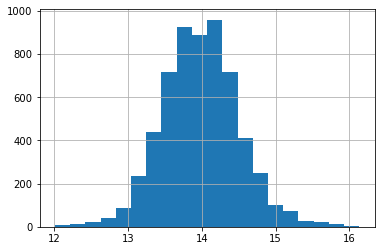

In [6]:
train[train['Annual Income'].notnull()]['Annual Income'].apply(np.log).hist(bins=20)
plt.show()

((array([-3.67998084, -3.44731998, -3.31922171, ...,  3.31922171,
          3.44731998,  3.67998084]),
  array([12.01125534, 12.0773582 , 12.08532209, ..., 16.00423735,
         16.04969689, 16.13291963])),
 (0.5213154415003348, 13.985768875812159, 0.9974228009115514))

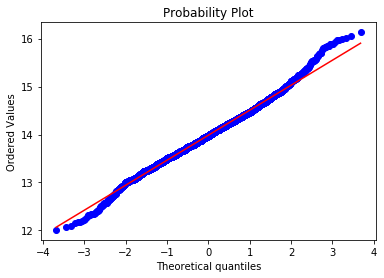

In [7]:
stats.probplot(train[train['Annual Income'].notnull()]['Annual Income'].apply(np.log), dist="norm", plot=plt)

Признак имеет выбросы около 1% и нулевые значения.
Приведем выбросы и нулевые значения к среднему значению в методе ControllerPrepare fillna_Annual_Income(self, df)

###### Years in current job - количество лет на текущем месте работы


In [8]:
train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

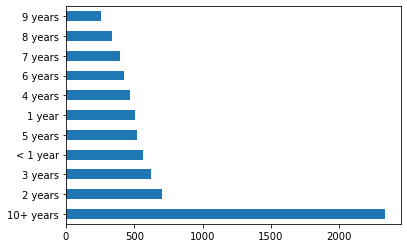

In [9]:
train['Years in current job'].value_counts().plot(kind='barh')

Признак явлется категориальным. Имеет  пропуск.
Наиболее вероятно, что признак не указан для тех у кого нет работы. Выделим в отдельную категорию 'unemployed' в функции fillna_Years_in_current_job.

###### Number of Open Accounts - количество открытых счетов

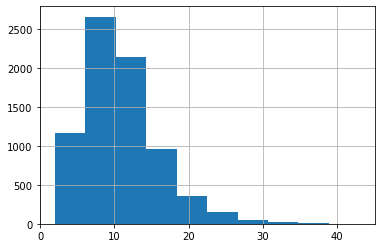

In [10]:
train['Number of Open Accounts'].hist()
plt.show()

Числовой признак без пропусков и явных выбросов

###### Years of Credit History - количество лет кредитной истории

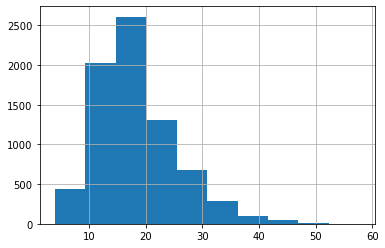

In [11]:
train['Years of Credit History'].hist()
plt.show()

Числовой признак без пропусков и явных выбросов

###### Number of Open Accounts - количество открытых счетов

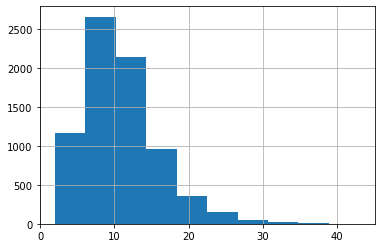

In [12]:
train['Number of Open Accounts'].hist()
plt.show()

Числовой признак без пропусков и явных выбросов

###### Maximum Open Credit -  наибольший открытый кредит

In [13]:
train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [14]:
dx = train[(np.abs(stats.zscore(train['Maximum Open Credit'])) > 3)]
print(dx.shape[0]/train.shape[0])

0.0005333333333333334


Есть выбросы. Заполним их средним значением. 

###### Number of Credit Problems -  количество проблем с кредитом

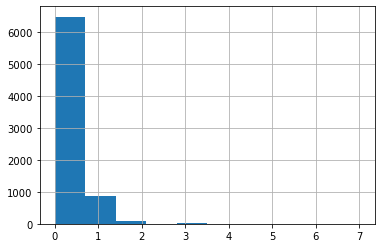

In [15]:
train['Number of Credit Problems'].hist()
plt.show()

Числовой признак без пропусков и явных выбросов

###### Months since last delinquent -  количество месяцев с последней просрочки платежа

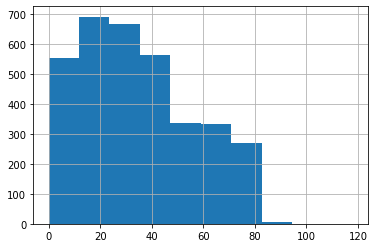

In [16]:
train['Months since last delinquent'].hist()
plt.show()

Выбросов нет. Пустые значения посмотрим с учетом целевого признака и количеством проблем с кредитом

In [17]:
train.loc[train['Months since last delinquent'].isnull(), TARGET_NAME].value_counts()

0    2951
1    1130
Name: Credit Default, dtype: int64

In [18]:
train.loc[train['Months since last delinquent'].isnull(), 'Number of Credit Problems'].value_counts()

0.0    3557
1.0     468
2.0      38
3.0      15
4.0       3
Name: Number of Credit Problems, dtype: int64

In [19]:
train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

Вероятно, пропуски в Months since last delinquent говорят о том, что ранее дефолтов не было по кредиту. 
Скорее всего это категориальный признак. 
Сделаем 2 варианта признака:
* числовой где null значение равно максимальному + std.
* разобъем на 5 категорий: без просрочки, оставшиеся квантили.

###### Bankruptcies -   банкротства

In [20]:
train.loc[ train[TARGET_NAME] == 1, 'Bankruptcies'].value_counts()

0.0    1878
1.0     217
2.0      11
3.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [21]:
train.loc[ train[TARGET_NAME] == 0, 'Bankruptcies'].value_counts()

0.0    4782
1.0     569
2.0      20
3.0       5
4.0       1
Name: Bankruptcies, dtype: int64

Заполниим пропуски наиболее часто встречающимся значением

###### Credit Score -   кредитная оценка

In [22]:
train.loc[train['Credit Score'].isnull(), TARGET_NAME].value_counts()

0    1028
1     529
Name: Credit Default, dtype: int64

In [23]:
train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Числовой признак с пропусками и выбросами заполним их средним значением

Подготовим тренировочный датасет

In [24]:
train = cprepare.get_and_prepare(train)
info_dataset(train, 'train')

Dataset:train
Название                      |Всего |Null-значений |Уникальных значений |Тип
Home Ownership                |  7500|             0|                   4|category
Annual Income                 |  7500|             0|                5449|float64
Years in current job          |  7500|             0|                  12|category
Tax Liens                     |  7500|             0|                   8|category
Number of Open Accounts       |  7500|             0|                  39|float64
Years of Credit History       |  7500|             0|                 408|float64
Maximum Open Credit           |  7500|             0|                6926|float64
Number of Credit Problems     |  7500|             0|                   8|float64
Months since last delinquent  |  7500|             0|                  90|float64
Bankruptcies                  |  7500|             0|                   5|float64
Purpose                       |  7500|             0|                  15|category
Te

###### Оценим корреляцию признаков:

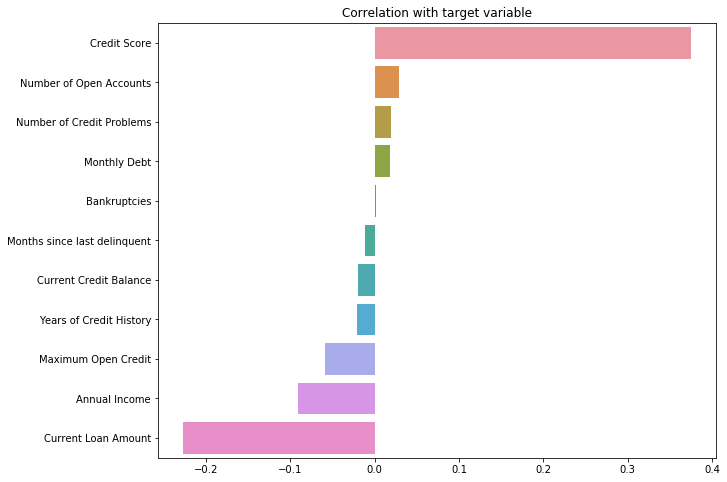

In [25]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

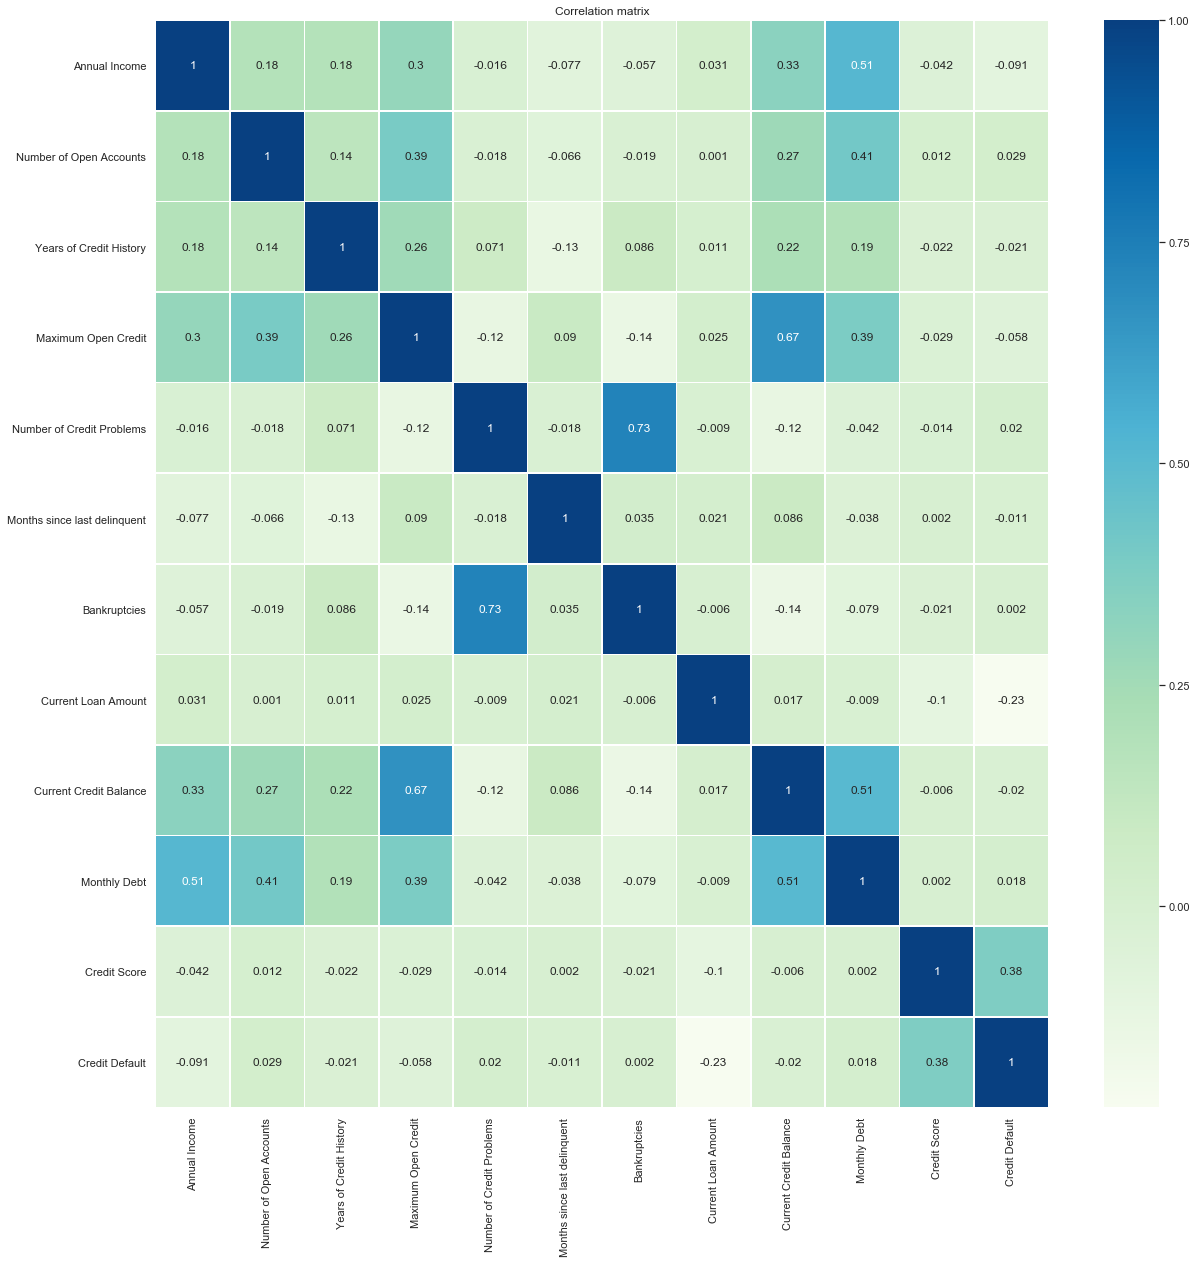

In [26]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1)
sns.heatmap(train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Есть значимая корреляция  
* между Maximum Open Credit и Current Credit Balance  
* Current Credit Balance и Monthly Debt  
* Bankruptcies и Number of Credit Problems  

Стоит оценить модель убрав один из признаков.

### Нормализация данных<a class="anchor" id="normalization"></a>

In [27]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score','Months since last delinquent'] 
CAT_FEATURE_NAMES = [train.columns.get_loc(col) for col in train.select_dtypes(include='category').columns]

In [28]:
train = cprepare.normalize(train,NUM_FEATURE_NAMES)

##### Разбиение на train и test

In [29]:
FEATURE_NAMES_SELECTED = train.columns.drop(TARGET_NAME)

In [30]:
X = train[FEATURE_NAMES_SELECTED]
y = train[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

##### Балансировка классов

In [31]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing[TARGET_NAME].value_counts()

0    4074
1    1551
Name: Credit Default, dtype: int64

In [32]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [33]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

##### Подбор моделей, получение бейзлана

In [34]:
cat_feats = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include='category').columns]

*CatBoost*

In [35]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_feats)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4074
           1       0.93      0.85      0.89      3102

    accuracy                           0.91      7176
   macro avg       0.91      0.90      0.91      7176
weighted avg       0.91      0.91      0.91      7176

VALID

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1313
           1       0.59      0.48      0.53       562

    accuracy                           0.75      1875
   macro avg       0.69      0.67      0.68      1875
weighted avg       0.73      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1126  187
1                291  271
Wall time: 26.2 s


##### Выбор наилучшей модели, настройка гиперпараметров

In [36]:
params = {'n_estimators': [50, 100, 200, 300, 500, 1000],
          'max_depth': [3, 5, 7, 9]}
cv = KFold(n_splits=3, random_state=21, shuffle=True)

In [37]:
#model = catb.CatBoostClassifier(class_weights=[1, 1.5], silent=True, random_state=21, cat_features=cat_feats)

In [38]:
#%%time
#rs = RandomizedSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1)
#rs.fit(X_train, y_train)

In [39]:
#BEST_PARAMS = rs.best_params_
BEST_PARAMS = {'n_estimators': 300, 'max_depth': 9}
BEST_PARAMS

{'n_estimators': 300, 'max_depth': 9}

In [40]:
#rs.best_score_

### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [41]:
L2_LEAF_REG = 100
ignored_features = ['Maximum Open Credit', 'Monthly Debt', 'Bankruptcies']
model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG, 
                                      #reg_lambda =100,
                                      ignored_features = ignored_features,
                                      n_estimators=BEST_PARAMS['n_estimators'], 
                                      max_depth=BEST_PARAMS['max_depth'],
                                      silent=True, 
                                      random_state=21, cat_features=cat_feats)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_probs = model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      4074
           1       0.79      0.56      0.65      3102

    accuracy                           0.74      7176
   macro avg       0.76      0.72      0.73      7176
weighted avg       0.75      0.74      0.73      7176

VALID

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1313
           1       0.60      0.48      0.53       562

    accuracy                           0.75      1875
   macro avg       0.70      0.67      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1132  181
1                291  271


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [42]:
CLASS_WEIGHTS = [1,1.5]
model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG, 
                                n_estimators=BEST_PARAMS['n_estimators'], 
                                max_depth=BEST_PARAMS['max_depth'],
                                class_weights=CLASS_WEIGHTS,
                                ignored_features = ignored_features,
                                silent=True, 
                                random_state=21, cat_features=cat_feats)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_probs = model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      4074
           1       0.66      0.78      0.72      3102

    accuracy                           0.73      7176
   macro avg       0.74      0.74      0.73      7176
weighted avg       0.75      0.73      0.74      7176

VALID

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1313
           1       0.46      0.70      0.56       562

    accuracy                           0.67      1875
   macro avg       0.65      0.68      0.65      1875
weighted avg       0.72      0.67      0.68      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               859  454
1               169  393


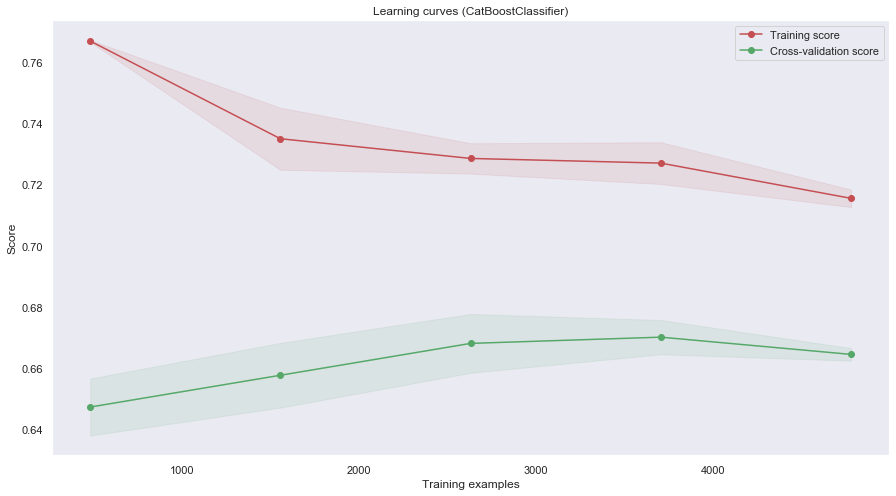

In [43]:
show_learning_curve_plot(model, X_train , y_train)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

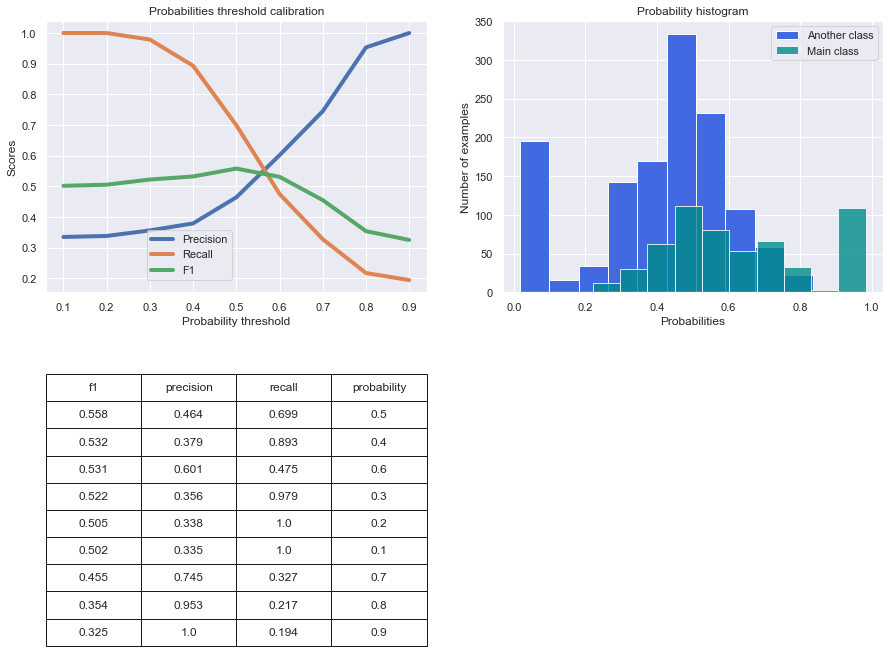

In [44]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

In [45]:
PROPOBILITY = 0.5

### Важность признаков<a class="anchor" id="feature_importances"></a>

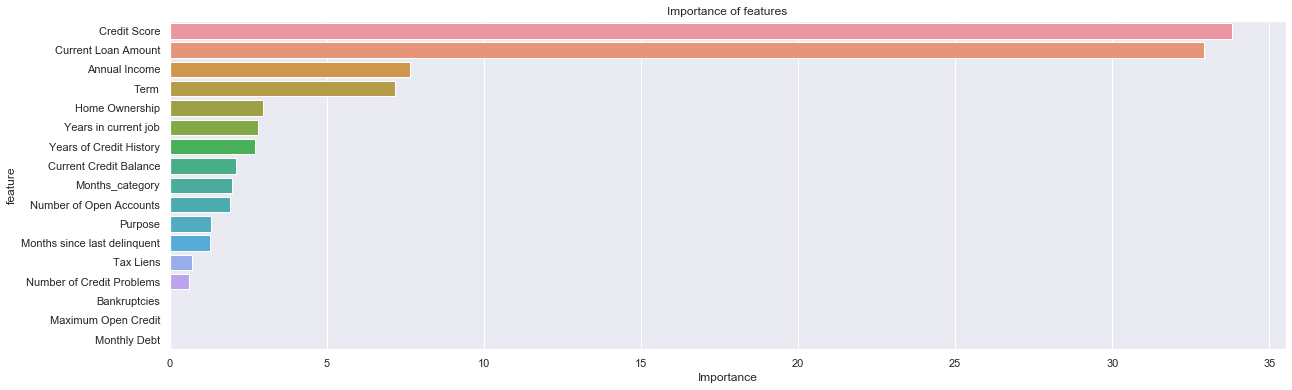

In [46]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=15)

In [47]:
FINAL_CAT_FEATS = []
for feat in important_features_top:
    print(f'{feat}:{X_train[feat].dtype}')
    if X_train[feat].dtype.name == 'category':
            FINAL_CAT_FEATS.append(feat)
for feat in ignored_features.copy():
    if feat not in important_features_top:
        ignored_features.remove(feat)

Credit Score:float64
Current Loan Amount:float64
Annual Income:float64
Term:category
Home Ownership:category
Years in current job:category
Years of Credit History:float64
Current Credit Balance:float64
Months_category:category
Number of Open Accounts:float64
Purpose:category
Months since last delinquent:float64
Tax Liens:category
Number of Credit Problems:float64
Bankruptcies:float64


### Финальная модель<a class="anchor" id="final_model"></a>

In [48]:
def bin_class_from_proba(y_valid_pred_probs):
    dx = pd.DataFrame(y_valid_pred_probs)
    dx[dx[1]>=PROPOBILITY] = 1
    dx[dx[1]<PROPOBILITY] = 0
    return dx[1].astype(int)

In [49]:
final_model = catb.CatBoostClassifier(l2_leaf_reg=L2_LEAF_REG,
                                n_estimators=BEST_PARAMS['n_estimators'], 
                                max_depth=BEST_PARAMS['max_depth'],
                                silent=True, 
                                class_weights=CLASS_WEIGHTS,
                                ignored_features = ignored_features,
                                random_state=21, cat_features=FINAL_CAT_FEATS)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred_probs = final_model.predict_proba(X_valid[important_features_top])
y_valid_pred = bin_class_from_proba(y_valid_pred_probs)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      4074
           1       0.67      0.78      0.72      3102

    accuracy                           0.74      7176
   macro avg       0.74      0.74      0.73      7176
weighted avg       0.75      0.74      0.74      7176

VALID

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      1313
           1       0.46      0.69      0.55       562

    accuracy                           0.66      1875
   macro avg       0.64      0.67      0.64      1875
weighted avg       0.72      0.66      0.68      1875

CONFUSION MATRIX

1                 0    1
Credit Default          
0               205  147
1                93   62


**Результат**

In [50]:
test = cprepare.prepare(test)
test = cprepare.normalize(test, NUM_FEATURE_NAMES)

In [51]:
test_predict = bin_class_from_proba(final_model.predict_proba(test[important_features_top]))
final_df = pd.DataFrame({'Id':range(7500, 10000),TARGET_NAME:test_predict.astype(int)})
final_df.to_csv('SShushakov_predictions.csv', index=False)
final_df[TARGET_NAME].value_counts()

1    1292
0    1208
Name: Credit Default, dtype: int64